# Philadelphia Bike Share Analysis 
This notebook analyzes Indego Bike Share usage in Phialadelphia from the launch of the service (April 2015) through 2017Q2. It primarily looks at the difference in usage between the Monthly membership riders (Indego30) and standard walk-up riders.

The data used for this analysis can be found here: https://www.rideindego.com/about/data/

Info about the different types of passes and their pricing for the service can be found here: https://www.rideindego.com/passes/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV


from packages.data import get_bike_data
from packages.daylight import hours_of_daylight

/Users/brandonkalnasy/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/brandonkalnasy/miniconda3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
data = get_bike_data()

#creates date and hour columns
ind = pd.DatetimeIndex(data.start_time)
data['date'] = ind.date.astype('datetime64')
data['hour'] = ind.hour

#dropping the 'One Day Pass' riders since there are only a few riders of that type in the whole dataset
data = data[data['passholder_type'] != 'One Day Pass']


On Indego's website there is nothing about One Day Passes and there are very few records in the dataset so I dropped them from the data.

### Bike Share Use Over Time

In [3]:
#creates pivot table with date and rider type
by_date = data.pivot_table('trip_id', aggfunc='count',
                            index='date',
                            columns='passholder_type')

#resamples the pivot table by week
by_week =  by_date.resample('w').sum()  

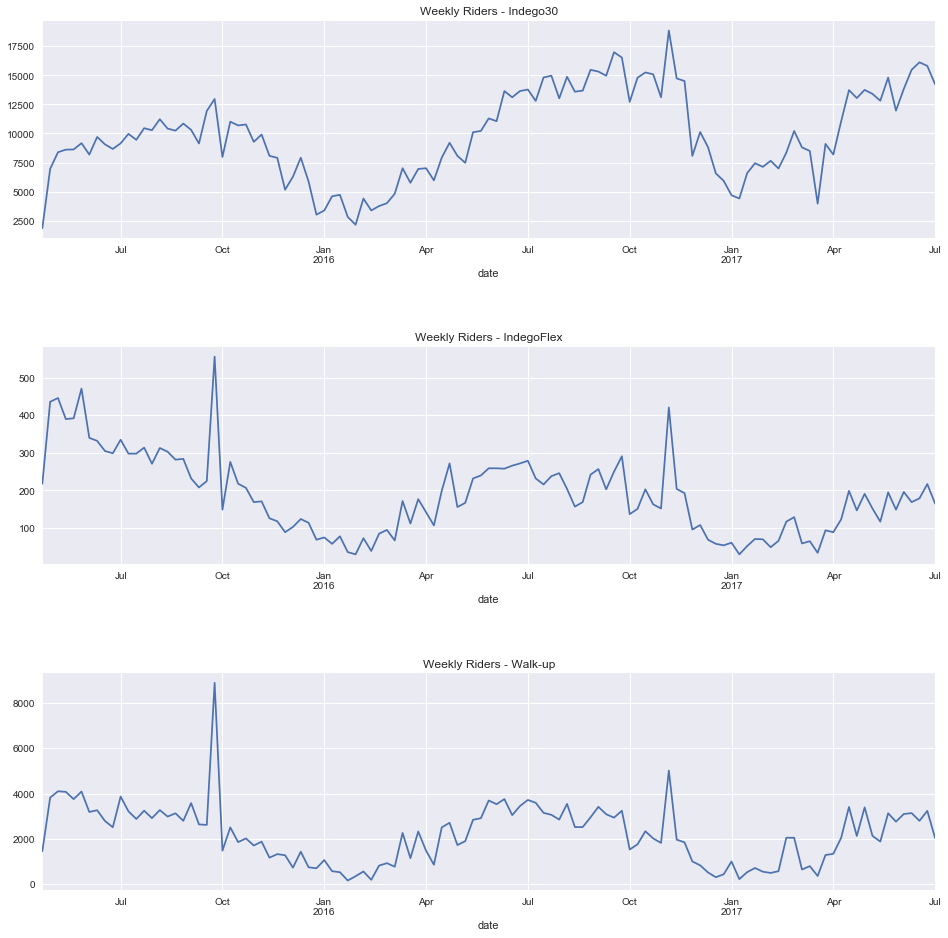

In [4]:
#plots the Daily rider counts by rider type

fig, ax = plt.subplots(3, figsize=(16, 16))
fig.subplots_adjust(hspace=.5)
by_week.iloc[:, 0].plot(ax=ax[0], title='Weekly Riders - Indego30');
by_week.iloc[:, 1].plot(ax=ax[1], title='Weekly Riders - IndegoFlex');
by_week.iloc[:, 2].plot(ax=ax[2], title='Weekly Riders - Walk-up');

- As expected there is higher use in warmer months compared to colder ones. Though, I wasn't expecting to see a higher share of use with Indego30 riders compared to walk-up riders.
- The sharp increase in Fall 2015 is from the week the Pope visited Philadelphia. Car traffic in the city was haulted for a few days leaving empty streets for cyclists to ride in.
- Slight increase in Fall 2016 is from the SEPTA worker strike, which shutdown public transportation for ~1 week



### Bike Share Use by Day of the Week

In [5]:
#groups the pivot table above by day of the week and year
by_weekday = by_date.groupby([by_date.index.year, by_date.index.dayofweek]).mean()

# remove label for plot
by_weekday.columns.name = None  

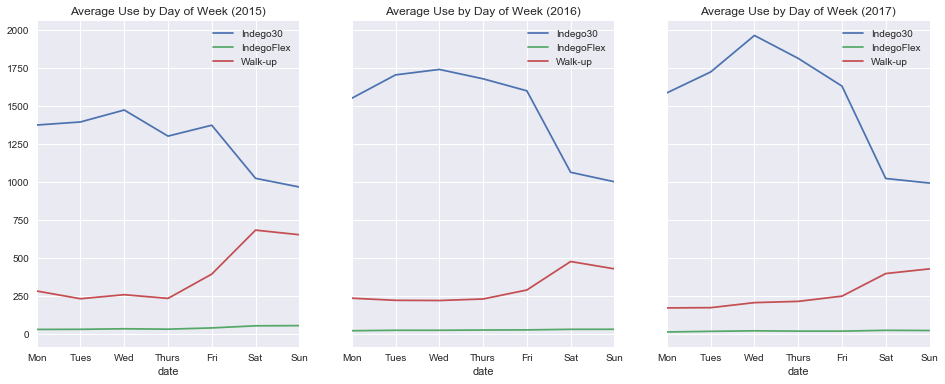

In [6]:
#plots the average rider count for each day of the week
fig, ax = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
by_weekday.loc[2015].plot(title='Average Use by Day of Week (2015)', ax=ax[0]);
by_weekday.loc[2016].plot(title='Average Use by Day of Week (2016)', ax=ax[1]);
by_weekday.loc[2017].plot(title='Average Use by Day of Week (2017)', ax=ax[2]);
for axi in ax:
    axi.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])

- The monthly-member riders show higher use on weekdays compared to weekends. This suggests that these riders use the service more for commuting compared to walk-up riders who ride more on the weekends.
- Monnthly-member use has increased year-over-year, whereas walk-up use has slightly decreased
    - Possibly due to the pricing of the Indego30 pass being more favorable than walk-up pricing
    
Note: Due to the small volume in IndegoFlex ridership, I will remove them from further analysis


In [7]:
data = data[data['passholder_type'] != 'IndegoFlex']

Now let's look at the ride use by hour to see if there are any trends there.

In [8]:
#creates a dataset that groups the riders counts by weekend/weekday and hour of the day 

# count trips by date and by hour
by_hour = data.pivot_table('trip_id', aggfunc='count',
                            index=['date', 'hour'],
                            columns='passholder_type').fillna(0).reset_index('hour')

# average these counts by weekend
by_hour['weekend'] = (by_hour.index.dayofweek >= 5)
by_hour = by_hour.groupby(['weekend', 'hour']).mean()
by_hour.index.set_levels([['weekday', 'weekend'],
                          ["{0}:00".format(i) for i in range(24)]],
                         inplace=True);
by_hour.columns.name = None

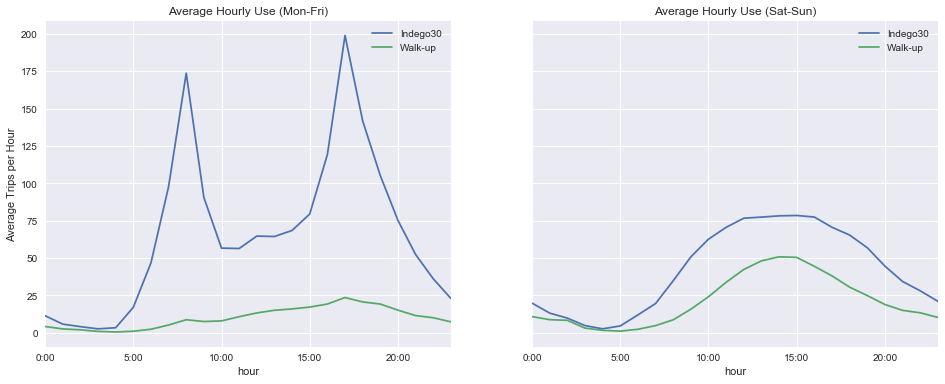

In [9]:
#plots the average rider count by hour of the day for weekdays and weekends
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
by_hour.loc['weekday'].plot(title='Average Hourly Use (Mon-Fri)', ax=ax[0]);
by_hour.loc['weekend'].plot(title='Average Hourly Use (Sat-Sun)', ax=ax[1]);
ax[0].set_ylabel('Average Trips per Hour');

- There is a clear 'commute' pattern for Indego30 rider on weekdays with sharp peaks in the morning and evening.
- Weekend ridership shows a 'recreational' pattern with a broad peak throughout the afternoon


### Trip Durations by Rider Type

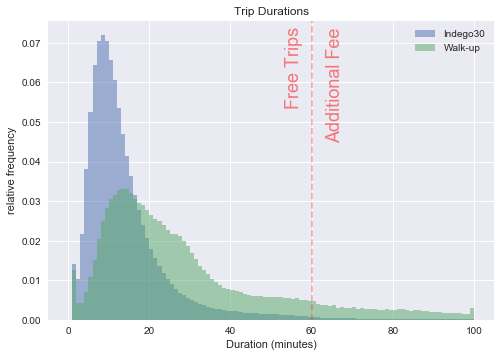

In [10]:
#plots and compares the distribution of the ride durations for Indego30 and Walk-up riders

#dropping IndegoFlex riders because of small volume
data[data['passholder_type'] != 'IndegoFlex'].groupby('passholder_type')['duration'].hist(bins=np.arange(101),
                                                                                          alpha=0.5, normed=True);
plt.xlabel('Duration (minutes)')
plt.ylabel('relative frequency')
plt.title('Trip Durations')
plt.legend(['Indego30', 'Walk-up'])

#Adds a line for the 60 min free time that Indego30 riders get with their membership 
plt.text(68, 0.06, "Free Trips\n\nAdditional Fee", ha='right',
         size=18, rotation=90, alpha=0.5, color='red')
plt.axvline(60, linestyle='--', color='red', alpha=0.3);

In [11]:
#percent of Indego30 riders who go over the free 60 minutes
(len(data[(data['passholder_type'] == 'Indego30') & (data['duration'] > 60)]) / len(data)) * 100

1.8441390244656206

- Indego30 riders are good about not going over the free 60 minute mark, with only 1.84% going over 1 hour
- Walk-up riders are more likely to ride for extended periods of time

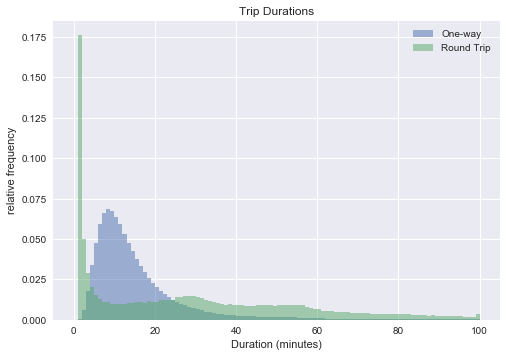

In [12]:
#plots and compares the distribution of the ride durations for Indego30 and Walk-up riders

#dropping IndegoFlex riders because of small volume
data[data['passholder_type'] != 'IndegoFlex'].groupby('trip_route_category')['duration'].hist(bins=np.arange(101),
                                                                                          alpha=0.5, normed=True);
plt.xlabel('Duration (minutes)')
plt.ylabel('relative frequency')
plt.title('Trip Durations')
plt.legend(['One-way', 'Round Trip']);

- There are a lot of Round Trips that are only 1 minute. Could be a data issue or due to riders having issues at the kiosks
    - Due to this I will only use One-way trips for the models below


### Predicting Trip Duration
Here I will create a few models from the sklearn library that will predict the trip duration based off the start and end stations for 'commuter' trips

In [13]:
#creating a dataset with the start_time to add day of week to data 
indexed_data = data.set_index('start_time', drop = False)
indexed_data['day_of_week'] = indexed_data.index.dayofweek

#creating dataframe of only one-way trips
one_way_trips = indexed_data[indexed_data['trip_route_category'] == 'One Way']


In [14]:
#creates sample data of 'commuter' trips
sample_data = one_way_trips[(one_way_trips['passholder_type'] == 'Indego30') & (one_way_trips['duration'] < 20) 
                            & (one_way_trips['day_of_week'] < 5)]

X = sample_data[['start_station_id','end_station_id']]
X = X.values

y = sample_data.duration
y = y.values

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

Classification score: 0.235367289735
Explained variance: 0.590008257043
R-square: 0.533657931533
MSE: 8.04569352993


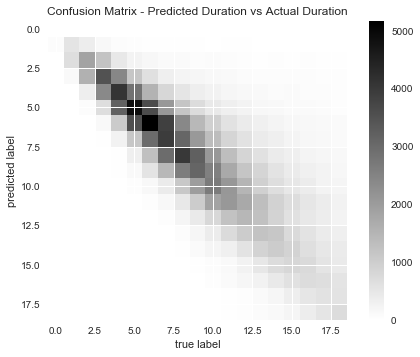

In [15]:
clf = DecisionTreeClassifier().fit(Xtrain, ytrain)
ypred_dt = clf.predict(Xtest)

plt.figure()
plt.imshow(metrics.confusion_matrix(ypred_dt, ytest),
           interpolation='nearest', cmap=plt.cm.binary)
plt.colorbar()
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.title("Confusion Matrix - Predicted Duration vs Actual Duration")

print("Classification score: " + str(clf.score(Xtest, ytest)))
print("Explained variance: " + str(metrics.explained_variance_score(ytest, ypred_dt)))
print("R-square: " + str(metrics.r2_score(ytest, ypred_dt)))
print("MSE: " + str(metrics.mean_squared_error(ytest, ypred_dt)))

Classification score: 0.235455746659
Explained variance: 0.584509926817
R-square: 0.536929030034
MSE: 7.98925801226


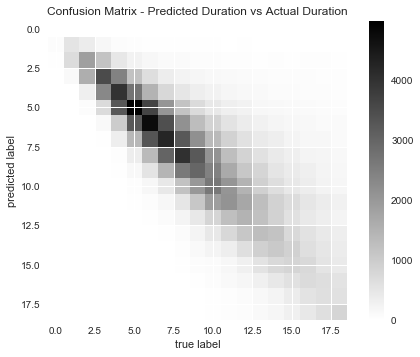

In [16]:
clf = RandomForestClassifier(n_estimators = 10).fit(Xtrain, ytrain)
ypred_rf = clf.predict(Xtest)

plt.figure()
plt.imshow(metrics.confusion_matrix(ypred_rf, ytest),
           interpolation='nearest', cmap=plt.cm.binary)
plt.colorbar()
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.title("Confusion Matrix - Predicted Duration vs Actual Duration")

print("Classification score: " + str(clf.score(Xtest, ytest)))
print("Explained variance: " + str(metrics.explained_variance_score(ytest, ypred_rf)))
print("R-square: " + str(metrics.r2_score(ytest, ypred_rf)))
print("MSE: " + str(metrics.mean_squared_error(ytest, ypred_rf)))

Classification score: 0.203672068068
Explained variance: 0.524478465772
R-square: 0.460692695578
MSE: 9.30454613305


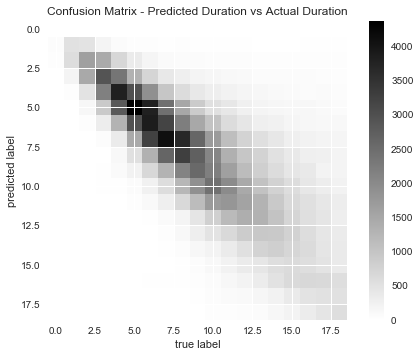

In [17]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors = 10).fit(Xtrain, ytrain)
ypred_knn = clf.predict(Xtest)

plt.figure()
plt.imshow(metrics.confusion_matrix(ypred_knn, ytest),
           interpolation='nearest', cmap=plt.cm.binary)
plt.colorbar()
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.title("Confusion Matrix - Predicted Duration vs Actual Duration")

print("Classification score: " + str(clf.score(Xtest, ytest)))
print("Explained variance: " + str(metrics.explained_variance_score(ytest, ypred_knn)))
print("R-square: " + str(metrics.r2_score(ytest, ypred_knn)))
print("MSE: " + str(metrics.mean_squared_error(ytest, ypred_knn)))

All three models have low classification scores, but the confusion matrices show that the models do a better job prediciting the duration of shorter trips than longer ones. 